In [1]:
%pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce


# model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)
# evaluation
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score

# Business Problem Understanding

**Context**  

[Sistem bisnis suatu bank](https://www.finpedia.id/info-keuangan/bisnis/sistem-proses-kerja-bank) yaitu menghimpun dana dari nasabah kemudian dikelola bank dengan meminjamkan lagi ke nasabah lain, investasi dan kegiatan operasional lainnya yang menghasilkan keuntungan.Salah satu produk keuangan bank menghimpun dana yaitu deposito berjangka. Mekanisme deposito berjangka adalah nasabah menyetor sejumlah uang di bank atau lembaga keuangan, dan uang tersebut hanya dapat ditarik setelah jangka waktu tertentu. Sebagai kompensasi, nasabah akan diberikan bunga tetap sesuai dengan jumlah nominal uang yang disetorkan. Dengan memiliki dana  yang terkunci dalam waktu tertentu bank dapat mengelola resiko likuiditas dengan lebih baik dan menjaga stabilitas keuangan mereka. 

Dengan semakin tingginya persaingan antar bank dalam menghimpun dana nasabah, selain mempertahankan nasabah lama maka bank juga membutuhkan kampanye pemasaran untuk menarik nasabah baru dengan menawarkan produk deposito berjangka. Salah satu cara pemasaran yang dilakukan adalah dengan menghubungi secara langsung melalui telepon/ seluler untuk  penawaran produk deposito. Akan tetapi, tidak semua nasabah tertarik untuk melakukan deposito sehingga terkadang biaya marketing yang dikeluarkan menjadi sia-sia.

Tim marketing ingin mengetahui nasabah mana yang berpotensi melakukan deposito sehingga dapat memaksimalkan pendapatan dari deposito dan meminimalisir biaya yang diperlukan untuk marketing.

**Problem Statement :**
Tantangan utama adalah membangun model yang membantu bank memprediksi pelanggan mana yang kemungkinan besar akan berlangganan deposito berjangka setelah kampanye pemasaran. Tujuannya adalah untuk mengurangi biaya perekrutan sambil meminimalkan risiko kehilangan calon nasabah potensial dengan fokus pada penargetan yang lebih tepat 


**Goals :** 

Maka berdasarkan permasalahan tersebut, perusahaan ingin memiliki kemampuan untuk memprediksi kemungkinan seorang nasabah akan/ingin menggunakan deposito berjangka tersebut atau tidak, sehingga dapat memfokuskan pemasaran pada nasabah yang tepat sasaran.

Dan juga, perusahaan ingin mengetahui apa/faktor/variabel apa yang membuat seorang nasabah tertarik atau tidak, sehingga mereka dapat membuat rencana yang lebih baik dalam mendekati nasabah potensial.

Saat dilakukan pengecekan hanya menggunakan rule based sederhana (Hanya dua fitur) akurasinya mencapai 38%. Maka diharapkan dengan model ML harus lebih baik dibandingkan hanya sekedar menggunakan rule based sederhana

**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan nasabah yang tertarik  denhgan produk deposito berjangka dan yang tidak tertarik.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang nasabah akan/ingin menggunakan produk deposito tersebut atau tidak.

**Metric Evaluation**

Sasaran analisis adalah sebagai berikut: 

0: Tidak (Tidak tertarik dengan deposito) 

1: Ya (Tertarik membuka rekening deposito)

Type 1 error : False Positive  
Definisi : Model memprediksi ada nasabah tertarik tapi tidak melakukan deposito.
Konsekuensi: sia-sianya biaya pemasaran, waktu dan sumber daya 
Contoh perhitungan: Jika biaya untuk menghubungi satu nasabah adalah 15 dolar, maka kerugian adalah: `270×15=4050 dolar

Type 2 error : False Negative  
Definisi : Nasabah masuk kategori yang terlewatkan tapi berniat melakukan deposito.
Konsekuensi: kehilangan calon potensial.
Contoh perhitungan: Jika satu nasabah yang melakukan deposito 300 dolar , maka potensi dana nasabah yang dilewatkan adalah:`285×300=85,300 dolar.`

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi cost pemasaran dari perusahaan tersebut, tetapi tanpa membuat menjadi kurangnya/tidak cukup kandidat potensial yang dibutuhkan perusahaan. Jadi kita ingin sebanyak mungkin prediksi kelas positif yang benar, dengan sesedikit mungkin prediksi false positive. Jadi nanti metric utama yang akan kita gunakan adalah f1 score

# Data Understanding

Dataset ini berisi informasi tentang profil pelanggan untuk kampanye pemasaran produk Bank,Deposito berjangka. Ada 11 kolom dan 7813 entri di dalam dataset Bank Marketing Campaign, yaitu:
* age: umur
* job : pekerjaan
* balance : saldo
* housing : perumahan
* loan  :pinjaman
* contact: Jenis komunikasi kontak.
* month: Bulan kontak terakhir dalam setahun.
* campaign: Jumlah kontak yang dilakukan selama kampanye ini dan untuk klien ini.
* pdays: Jumlah hari setelah klien dihubungi dari kampanye sebelumnya.
* poutcome: Hasil dari kampanye pemasaran sebelumnya.
*	deposit: Apakah pelanggan menyetor atau tidak.


In [3]:
data_ori = pd.read_csv('data_bank_marketing_campaign.csv')
data_ori

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no


In [6]:
# melihat unique data pada masing-masing kolom
def Check (x):
    Type = []
    Count = []
    Sample = []
    MissVal = []
    for i in x.columns:
        Sample.append(x[i].unique()[:5])
        Count.append(x[i].nunique())
        Type.append(x[i].dtype)
        MissVal.append(x[i].isna().sum())
    check = pd.DataFrame({
        'Columns' : data_ori.columns,
        'Dtype' : Type,
        'Nunique' : Count,
        'Missing Value' : MissVal,
        'Unique' : Sample
    })
    return check

In [7]:
Check (data_ori)

,Columns,Dtype,Nunique,Missing Value,Unique
0,age,int64,75,0,"[55, 39, 51, 38, 36]"
1,job,object,12,0,"[admin., self-employed, services, housemaid, t..."
2,balance,int64,3153,0,"[1662, -3058, 3025, -87, 205]"
3,housing,object,2,0,"[no, yes]"
4,loan,object,2,0,"[no, yes]"
5,contact,object,3,0,"[cellular, telephone, unknown]"
6,month,object,12,0,"[jun, apr, may, nov, jan]"
7,campaign,int64,32,0,"[2, 3, 1, 4, 5]"
8,pdays,int64,422,0,"[-1, 352, 21, 91, 186]"
9,poutcome,object,4,0,"[unknown, other, failure, success]"


In [8]:
# Menghitung jumlah nilai 'unknown' pada setiap kolom
jumlah_unknown = (data_ori == 'unknown').sum()

# Membuat DataFrame dari hasil perhitungan
jumlah_unknown = pd.DataFrame(jumlah_unknown, columns=['jumlah'])
total_baris_data = len(data_ori)
jumlah_unknown['persentase %'] = round((jumlah_unknown['jumlah'] / total_baris_data) * 100, 2)
jumlah_unknown

,jumlah,persentase %
age,0,0.00
job,54,0.69
balance,0,0.00
housing,0,0.00
loan,0,0.00
contact,1639,20.98
month,0,0.00
campaign,0,0.00
pdays,0,0.00
poutcome,5819,74.48


## Missing Values

In [9]:
# Jumlah data kosong (NaN) untuk setiap variable
missing = pd.DataFrame({'jumlah':data_ori.isnull().sum().sort_values(ascending = False)})
total_baris_data = len(data_ori)
missing['persentase %'] = round((missing['jumlah']/total_baris_data)*100,2)
missing

,jumlah,persentase %
age,0,0.0
job,0,0.0
balance,0,0.0
housing,0,0.0
loan,0,0.0
contact,0,0.0
month,0,0.0
campaign,0,0.0
pdays,0,0.0
poutcome,0,0.0


Dari hasil pengecekan jumlah data kosong disimpulkan bahwa tidak ada data yang kosong.

## Data Duplicate

In [10]:
# jumlah yang duplikat
data_ori.duplicated().sum()

8

In [11]:
# untuk memunculkan data yang duplikat
data_ori[data_ori.duplicated()]

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
2944,40,blue-collar,0,yes,no,unknown,may,2,-1,unknown,no
4368,60,management,0,no,no,cellular,aug,3,-1,unknown,yes
4874,41,management,0,no,no,cellular,aug,2,-1,unknown,no
5326,44,blue-collar,0,yes,no,cellular,jul,1,-1,unknown,no
5609,39,technician,0,yes,no,unknown,may,1,-1,unknown,no
5681,38,technician,0,no,no,cellular,aug,2,-1,unknown,no
5905,34,management,0,no,no,cellular,aug,2,-1,unknown,no
7077,30,blue-collar,239,yes,no,unknown,may,1,-1,unknown,yes


In [4]:
# mendrop data dupliat
data_ori.drop_duplicates(inplace = True)

Setelah dilakukan pengecakan terdapat 8 data duplikat kemudian dilakukan penghapusan data tersebut.

## Variable Numerik

### Statistika Deskriptif

In [13]:
data_ori.describe()

,age,balance,campaign,pdays
count,7813.000000,7813.000000,7813.000000,7813.000000
mean,41.257264,1512.448611,2.519775,51.408550
std,11.919710,3089.291831,2.727001,108.072739
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,127.000000,1.000000,-1.000000
50%,39.000000,549.000000,2.000000,-1.000000
75%,49.000000,1684.000000,3.000000,40.000000
max,95.000000,66653.000000,63.000000,854.000000


secara desripsi kita dapat ketahui terdapat nilai count, mean, standar deviasi, min, max, median pada 4 data numerik

### Distribusi Data

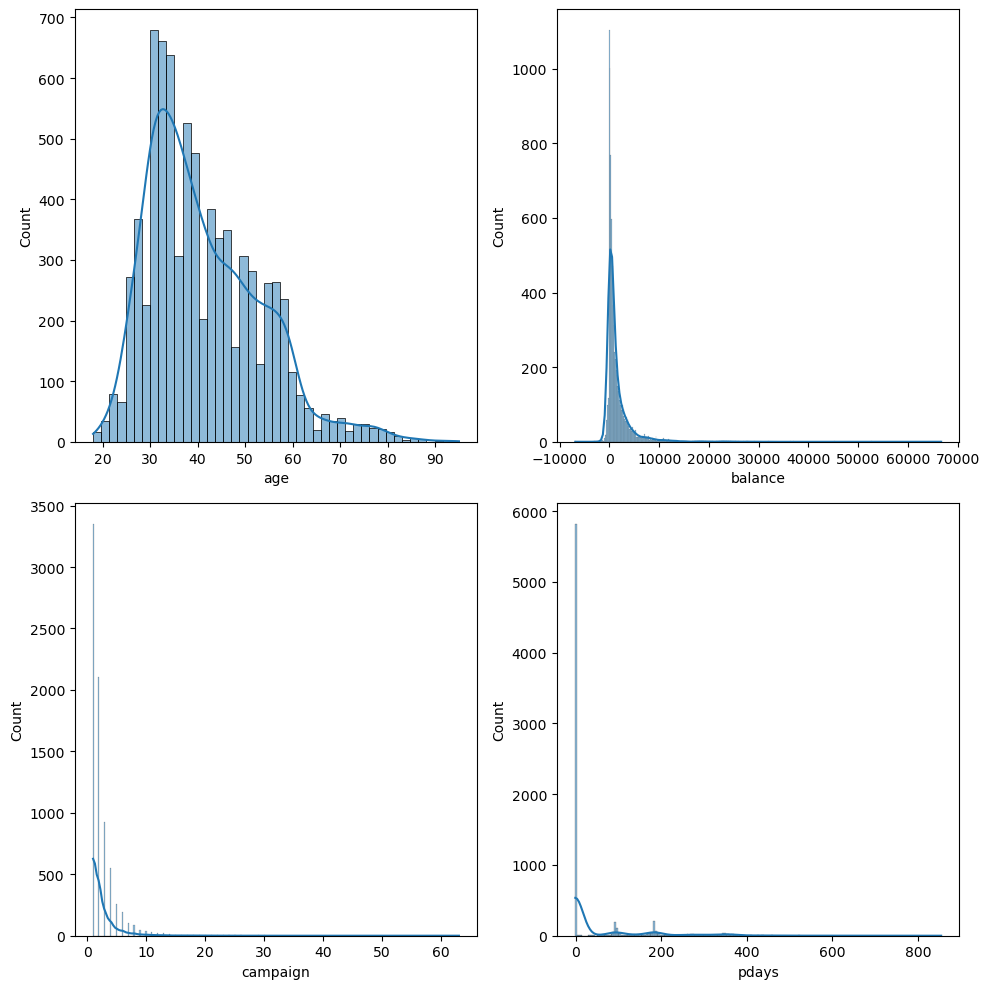

In [14]:
numerik = data_ori.select_dtypes(include='number')

# Mengatur ukuran grafik
plt.figure(figsize=(10, 10))

# Hitung jumlah kolom numerik
jumlah_kolom = len(numerik.columns)


# Membagi jumlah kolom dengan 2 agar subplot diatur dalam 2 kolom
baris = (jumlah_kolom + 1) // 2

posisi = 1  # Inisialisasi posisi mulai dari 1
for setiap_kolom in numerik.columns:  # Iterasi tiap kolom numerik
    plt.subplot(baris, 2, posisi)  # Sesuaikan subplot dengan jumlah baris dan kolom
    sns.histplot(numerik[setiap_kolom], kde=True)
    posisi += 1
    plt.tight_layout()  # Agar layout tidak bertumpuk

In [15]:
##UJI STATISTIKA
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [16]:
# D'Agustino Pearson
from scipy.stats import normaltest

for column in numerik :

        stat, pval = normaltest(data_ori[column])
        print(f"Kolom: {column}")
        if pval < 0.05:
            print('Data tidak normal \n')
        else:
            print('Data normal \n')

Kolom: age
Data tidak normal 

Kolom: balance
Data tidak normal 

Kolom: campaign
Data tidak normal 

Kolom: pdays
Data tidak normal 



### Outliers

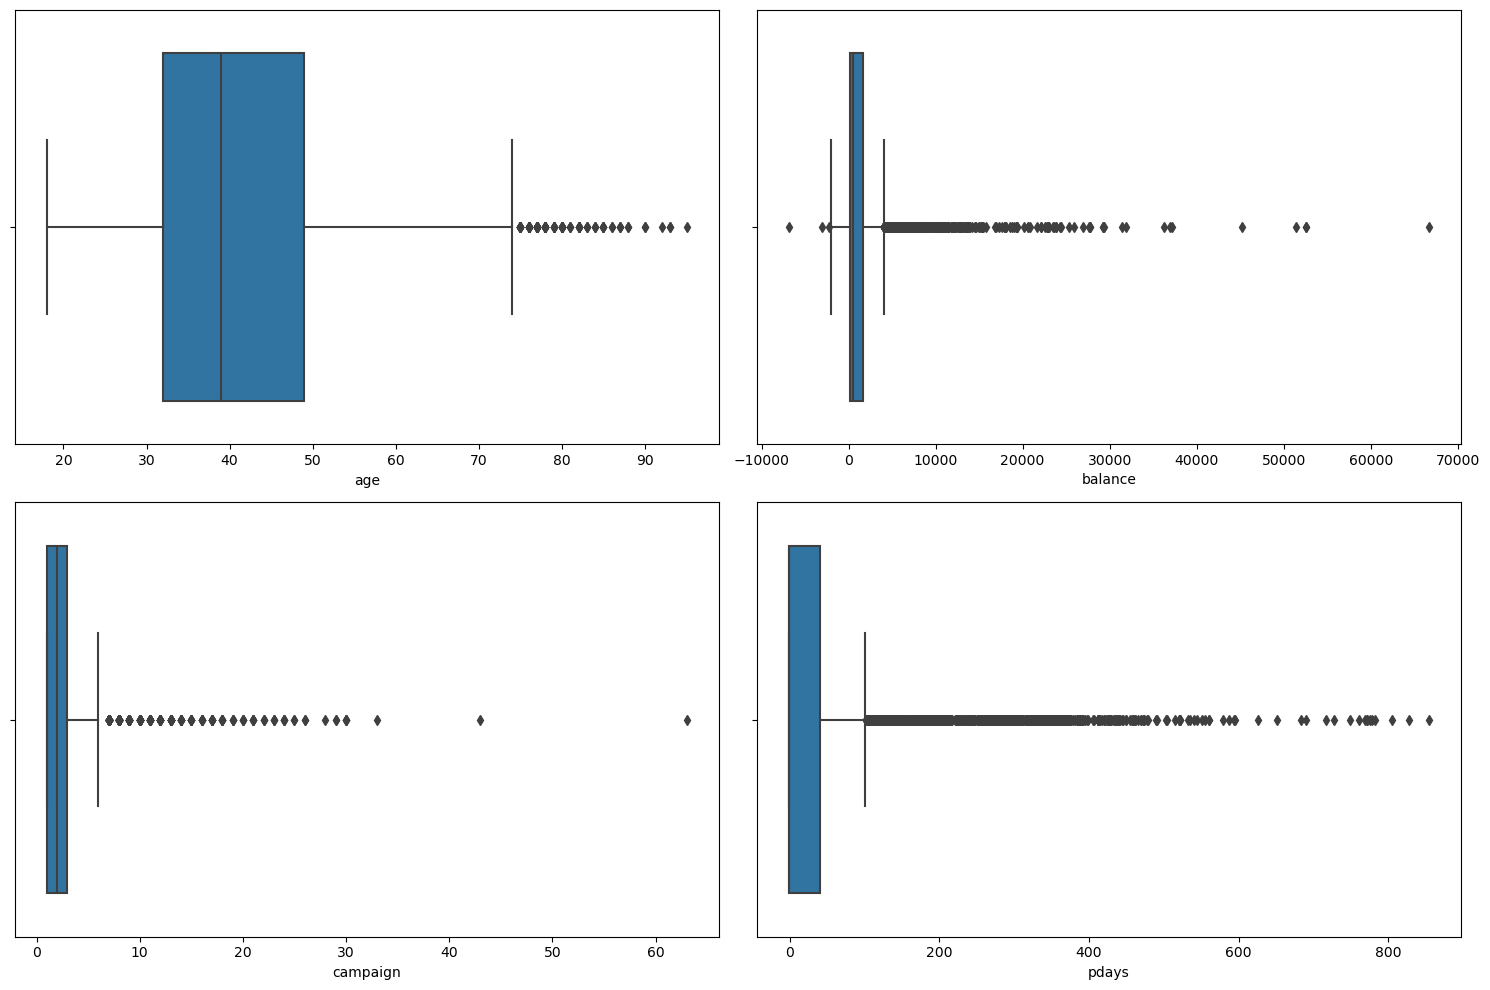

In [18]:
# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (15,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(2,2,posisi)
    sns.boxplot(x = data_ori[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

Dari hasil boxplot diketahui hampir disemua fitur numerik.

In [19]:
# Inter Quartile Range (IQR) * 1.5
list_jumlah_outliers = []
list_persentase_outliers = []
total_data = 7085

for setiap_kolom in numerik.columns:
    q3 = numerik.describe()[setiap_kolom]['75%']
    q1 = numerik.describe()[setiap_kolom]['25%']
    iqr = q3 - q1
    whis = 1.5 * iqr
    upper_bound = q3 + whis
    lower_bound = q1 - whis

    jumlah_outliers = len(numerik[(numerik[setiap_kolom] > upper_bound) | (numerik[setiap_kolom] < lower_bound)])
    list_jumlah_outliers.append(jumlah_outliers)

    # Menghitung persentase outlier
    persentase_outliers = round((jumlah_outliers / total_data) * 100,2)
    list_persentase_outliers.append(persentase_outliers)

# Membuat DataFrame dengan jumlah dan persentase outliers
pd.DataFrame({
    'kolom': numerik.columns,
    'jumlah outliers': list_jumlah_outliers,
    'persentase %': list_persentase_outliers
})

,kolom,jumlah outliers,persentase %
0,age,121,1.71
1,balance,736,10.39
2,campaign,429,6.06
3,pdays,1454,20.52


Dengan menggunakan *Inter Quartile Range (IQR) * 1.5* maka dapat diketahui jumlah outlier dan persentase pada dataset.Dimana persentase outliers tertinggi 20,21% dan terendah 1,71%

### Korelasi

In [20]:
numerik.corr(method = 'spearman')

,age,balance,campaign,pdays
age,1.000000,0.100600,0.023335,0.009668
balance,0.100600,1.000000,-0.036909,0.090169
campaign,0.023335,-0.036909,1.000000,-0.124030
pdays,0.009668,0.090169,-0.124030,1.000000


<Axes: >

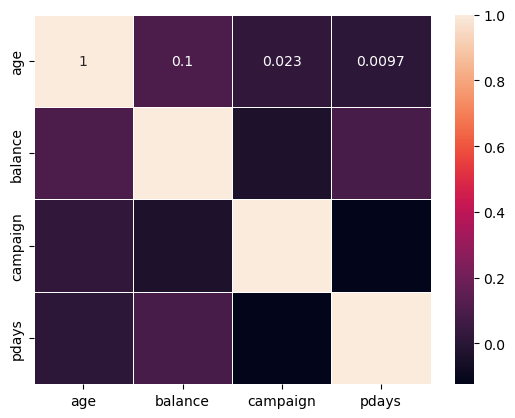

In [21]:
sns.heatmap(numerik.corr(method = 'spearman'), annot = True, linewidths=0.5)

### Multikolineartias dengan VIF

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# buat function
def calc_vif(x):
    # dataframe kosong
    vif = pd.DataFrame()
    vif['variables'] = x.columns
    # menghitung vig untuk setiap kolom nya
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif

In [23]:
calc_vif(numerik)

,variables,VIF
0,age,2.251170
1,balance,1.250455
2,campaign,1.749270
3,pdays,1.214082


Karena hasil VIF sangat kecil dari 5 maka apat disimpulakan tidak ada multikolinearitas

## Variabel Kategorik

### Describe

In [24]:
data_ori.describe(include = 'object')

,job,housing,loan,contact,month,poutcome,deposit
count,7813,7813,7813,7813,7813,7813,7813
unique,12,2,2,3,12,4,2
top,management,no,no,cellular,may,unknown,no
freq,1792,4140,6789,5628,1976,5819,4081


### Unique Values

In [26]:
kategorik = data_ori.select_dtypes(include = 'object')
kategorik.nunique()


job         12
housing      2
loan         2
contact      3
month       12
poutcome     4
deposit      2
dtype: int64

### Value Counts

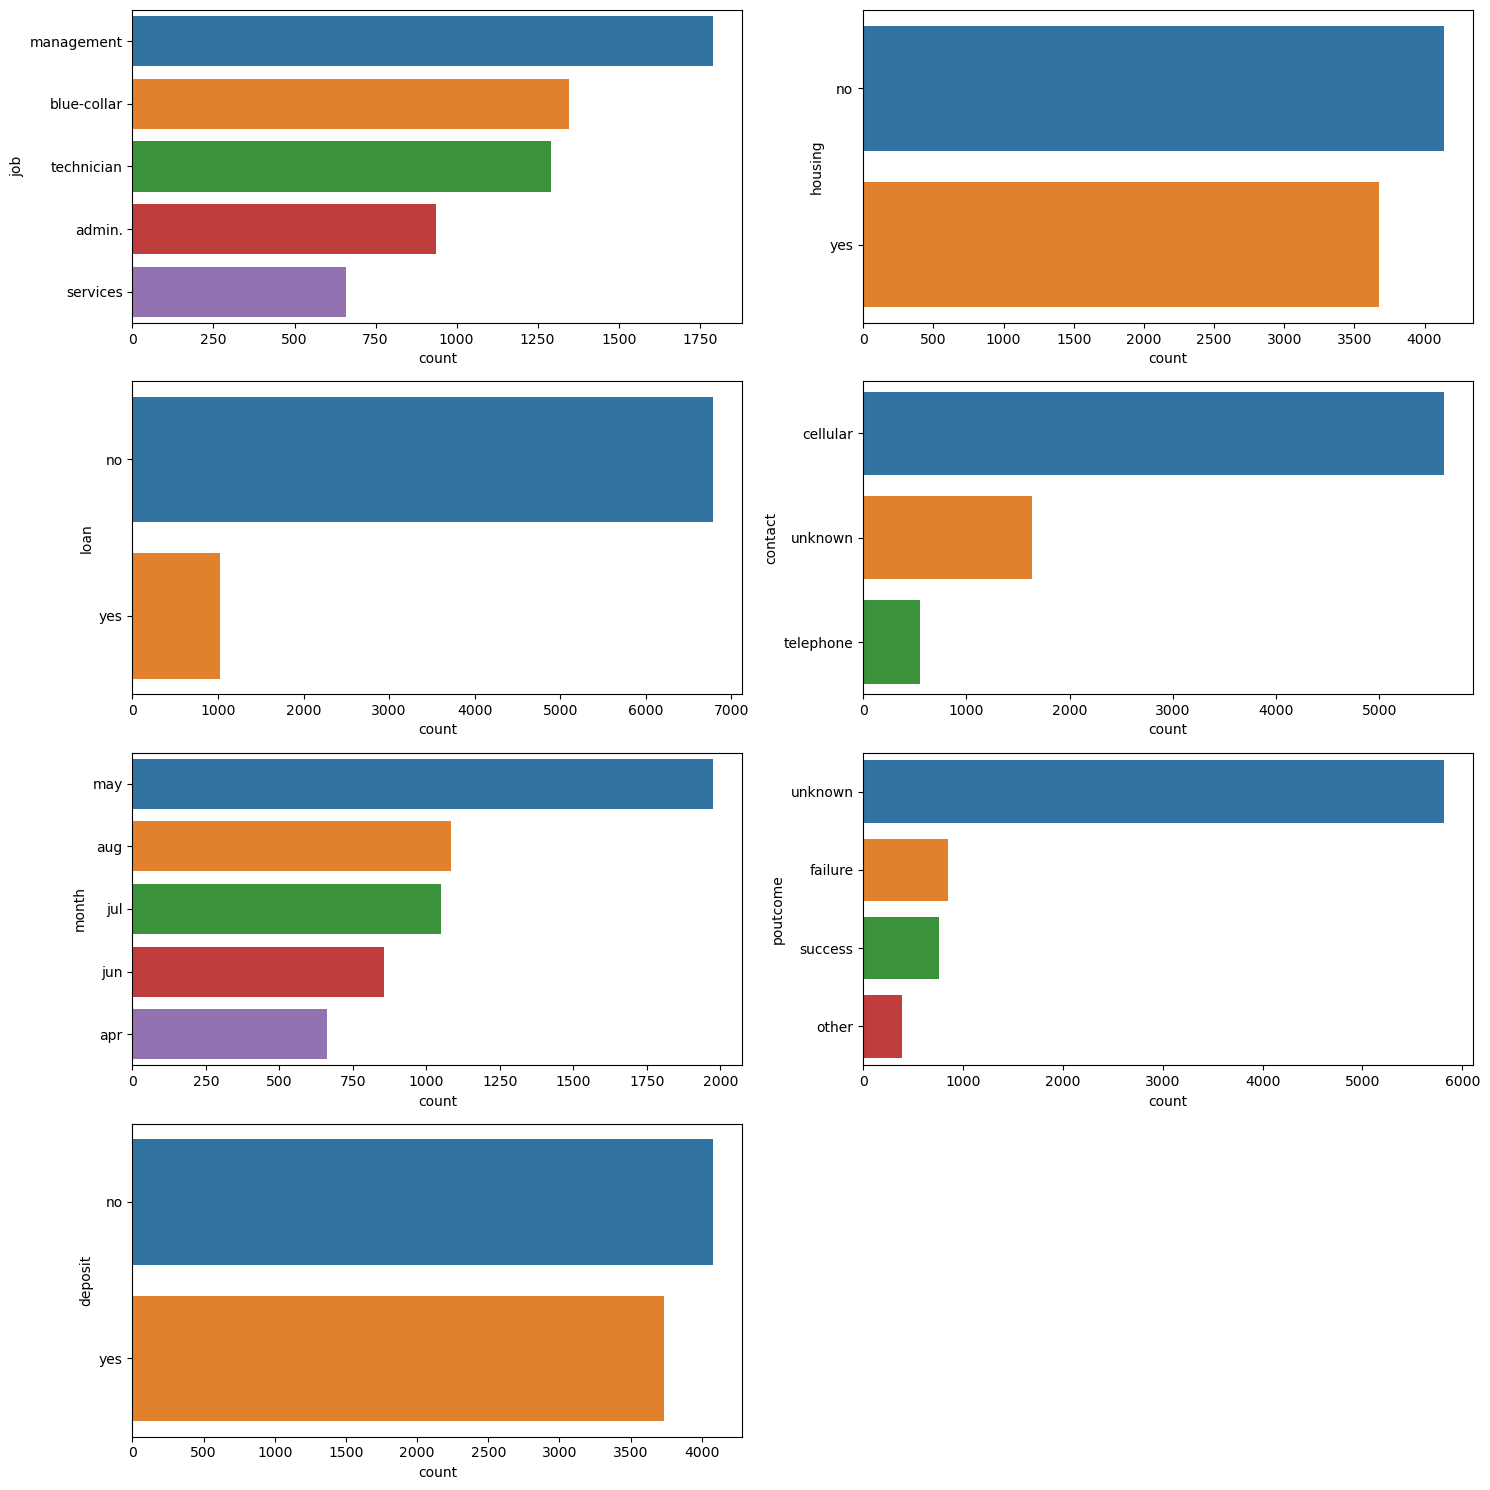

In [27]:
#Dibuat histogram
plt.figure(figsize = (15,15)) # (horizontal, vertikal)

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in kategorik.columns: # kategorik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    values = kategorik [setiap_kolom].value_counts().head().reset_index()
    values.columns = [setiap_kolom,'count']
    sns.barplot(x =values['count'],y = values[setiap_kolom], orient = 'h')
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

In [30]:
data_ori['job'].value_counts()

job
management       1792
blue-collar      1346
technician       1291
admin.            936
services          658
retired           540
self-employed     280
unemployed        249
student           247
entrepreneur      236
housemaid         184
unknown            54
Name: count, dtype: int64

In [32]:
data_ori['poutcome'].value_counts()

poutcome
unknown    5819
failure     848
success     761
other       385
Name: count, dtype: int64

# Data Cleaning

Dari proses Data Understanding diketahui bahwa tidak ada data yang hilang tapi memiliki data 'unknown pada `job`, `contact` dan `poutcome`

In [34]:
data_with_outlier = data_ori.copy()

In [35]:
data_with_outlier

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
7808,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes
7809,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes
7810,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no
7811,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no


## `Job`

Data unknown pada fitur job berkisar 0,6% maka diputuskan data akan tetap dipertahankan dan direplace menjadi pekerjaan lain2 other

In [37]:
# Mengagnti data unknown menjadi other
data_with_outlier['job'].replace('unknown', 'other', inplace=True)

In [42]:
# Melihat jumlah kemunculan setiap nilai dalam kolom 'job'
job_count = data_with_outlier['job'].value_counts()
pd.DataFrame(job_count)

,count
job,
management,1792
blue-collar,1346
technician,1291
admin.,936
services,658
retired,540
self-employed,280
unemployed,249
student,247


## `contact`

Dari hasil perhitungan jumlah data 'unknown' pada `contact` sebesar 20,98 %. Melihat kategori  yang ada hanya 'cellular'dan 'telphone' bisa dikatakan proses pemasaran dilakukan komunikasi secara langsung dengan nasabah maka diputuskan menggantinya dengan dengan nilai modus

In [43]:
data_with_outlier.contact.value_counts()

contact
cellular     5628
unknown      1639
telephone     546
Name: count, dtype: int64

In [44]:
# Menghitung modus dari kolom 'job'
modus_contact = data_with_outlier['contact'].mode()[0]

# Mengganti 'unknown' dengan modus
data_with_outlier['contact'].replace('unknown', modus_contact, inplace=True)

In [45]:
(data_with_outlier['contact'] == 'unknown').sum()

0

In [46]:
data_with_outlier.contact.value_counts()

contact
cellular     7267
telephone     546
Name: count, dtype: int64

## `poutcome`

Dari hasil pengecekan diketahui 'poutcome' memiliki 4 unik values: success, failure, other dan unknown (74,48%) maka bisa dibandingkan dengan kolom "deposit" yang secara jelas menunjukkan bahwa nasabah membuka rekening atau tidak dengan checking menggunakan pivot table.

In [47]:
# Membuat pivot table
pivot_table = pd.pivot_table(data_with_outlier, 
                             index='poutcome', 
                             columns='deposit', 
                             aggfunc='size', 
                             fill_value=0)

print(pivot_table)

deposit     no   yes
poutcome            
failure    413   435
other      159   226
success     65   696
unknown   3444  2375


Dari pivot table  terlihat bahwa tidak ada indikasi hubungan antara unknown dan other terhadap deposito yang dibuat, karena baik other maupun unknown memiliki beberapa nilai di "no" dan "yes". 

Dari table terlihat ada nasabah yang secara kategori masuk ke dalam "sukses" di program pemasaran sebelumnya, namun  tidak melakukan deposit dananya. (poutcome = success tapi deposit = no)

sebaliknya ada juga nasabah yang secara kategori masuk ke dalam "gagal" di program pemasaran sebelumnya, namun justru melakukan penempatan dana di bank. (poutcome = failure tapi deposit = yes)

Dapat disimpulkan bahwa data tidak menentukan terhadap keputusan kesuksesan deposito, maka kolom poutcome akan tetap direplace menjadi other agar menyerderhanakan kategorik.

In [48]:
# Mengagnti data unknown menjadi other
data_with_outlier['poutcome'].replace('unknown', 'other', inplace=True)

In [49]:
data_with_outlier.poutcome.value_counts()

poutcome
other      6204
failure     848
success     761
Name: count, dtype: int64

## `pdays`

Pada colom pdays terdapat nilai -1. nilai -1 diartikan sebagai customer yang tidak dihubungi di periode kampanye sebelumnya. nilai -1 pada kolom pdays ini akan diganti menjadi 0, agar tidak memberikan nilai saat pemodelan.


In [50]:
# mengganti data pada kolom pdays dari -1 ke 0
data = data_with_outlier.replace(-1,0, inplace =True)

## Outliers `age` , `balance` , `pdays` dan `campaign`

Terdapat data outliers pada semua kolom numerikal, tetapi akan diabaikan dan tetap digunakan untuk pembuatan model karena dianggap sesuai dengan kondisi aktual.

Age : sangat wajar terdapat beberapa nasabah yang usianya sudah lanjut dan masih dapat dihubungi.

Balance : sangat wajar terdapat nasabah-nasabah dengan saldo tinggi. (jumlah nasabah prioritas lebih sedikit daripada nasabah umum)

pdays : sangat wajar nasabah yang pernah dihubungi pada suatu program, namun karena tidak memberikan respon positif maka tidak dihubungi lagi untuk program berikutnya.

campaign : sangat wajar terdapat nasabah yang tidak mengangkat telepon sehingga petugas menghubungi nasabah tersebut berkali-kali.

In [41]:
age_count = data_with_outlier['age'].value_counts()
age_count

age
31    351
32    344
30    329
35    324
33    317
     ... 
93      2
86      2
90      2
92      1
95      1
Name: count, Length: 75, dtype: int64

In [56]:
age_count = data_with_outlier['campaign'].value_counts()
age_count.head(10)

campaign
1     3354
2     2108
3      922
4      548
5      256
6      196
7      103
8       89
9       47
10      41
Name: count, dtype: int64

# Data Analysis

Sebagaimana dijelaskan sebelumnya, kita akan menggunakan parameter "deposit" sebagai tolak ukur kesuksesan (yes & no). 

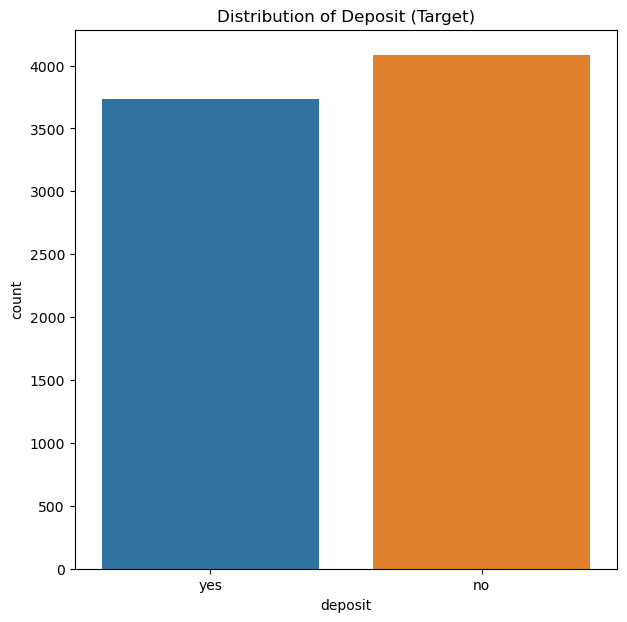

In [58]:
plt.figure(figsize=(7, 7))
sns.countplot(x='deposit', data=data_with_outlier)
plt.title('Distribution of Deposit (Target)')
plt.show()

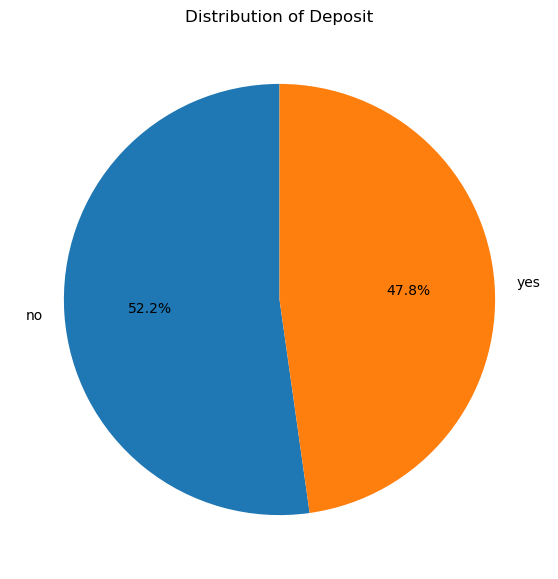

In [59]:
#Menggunakan piechart
plt.figure(figsize=(7, 7))
plt.pie(data_with_outlier['deposit'].value_counts(), labels=data_with_outlier['deposit'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Deposit')
plt.show()

Perbandingan depositor antara '(Yes)' dan '(No)' relatif seimbang, sehingga tidak diperlukan treatment data imbalance.

# Data Splitting

In [60]:
X = data_with_outlier.drop('deposit', axis=1)
y = data_with_outlier['deposit'].map({'yes': 1, 'no': 0})

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42,
    stratify = y 
)

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6250, 10), (1563, 10), (6250,), (1563,))

# Data Preparation

In [64]:
data_with_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


Fitur yang belum bertipe data numerik, akan dilakukan encoding/preprosesing terlebih dahulu agar dapat masuk dalam pemodelan.

Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki. Yang akan kita lakukan adalah :
1. Merubah fitur/kolom `job` menggunakan Binary Encoding, karena fitur ini tidak memiliki  jumlah unique lebih dari 5.
2. Merubah fitur/kolom `housing` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit = 2.
3. Merubah fitur/kolom `loan` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit = 2.
4. Merubah fitur/kolom `contact` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit = 2.
5. Merubah fitur/kolom `month` menggunakan Ordinal Encoding, karena fitur ini memiliki urutan dan punya 12 unique.
6. Merubah fitur/kolom `poutcome` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit = 4.

RobustScaler pada semua kolom numerik (semua data tidak normal)agar bisa mengurangi pengaruh outlier.


In [65]:
ordinal_mapping = [
    {'col':'month',
    'mapping':{
        'jan'       :    1,
        'feb'       :    2, 
        'mar'       :    3, 
        'apr'       :    4, 
        'may'       :    5, 
        'jun'       :    6,
        'jul'       :    7,
        'aug'       :    8,
        'sep'       :    9, 
        'oct'       :    10, 
        'nov'       :    11, 
        'dec'       :    12,
    }}
]

In [66]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop = 'first'), ['housing','loan','contact','poutcome']),
    ('binary', BinaryEncoder(), ['job']),
    ('ordinal', ce.OrdinalEncoder(mapping = ordinal_mapping), ['month']),
    ('scaler', RobustScaler(), X_train.select_dtypes(include = 'number').columns)
], remainder = 'passthrough')
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot', OneHotEncoder(drop='first'),
                                 ['housing', 'loan', 'contact', 'poutcome']),
                                ('binary', BinaryEncoder(), ['job']),
                                ('ordinal',
                                 OrdinalEncoder(mapping=[{'col': 'month',
                                                          'data_type': dtype('O'),
                                                          'mapping': jan     1
feb     2
mar     3
apr     4
may     5
jun     6
jul     7
aug     8
sep     9
oct    10
nov    11
dec    12
dtype: int64}]),
                                 ['month']),
                                ('scaler', RobustScaler(),
                                 Index(['age', 'balance', 'campaign', 'pdays'], dtype='object'))])

In [68]:
x_train_preprocessed = transformer.fit_transform(X_train)
x_train_preprocessed

array([[ 1.        ,  0.        ,  0.        , ...,  0.00447642,
         0.        ,  3.5       ],
       [ 1.        ,  0.        ,  0.        , ..., -0.10615508,
        -0.5       ,  0.        ],
       [ 1.        ,  0.        ,  0.        , ..., -0.31143086,
        -0.5       ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.33445244,
         0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        , ..., -0.34916067,
         0.        ,  0.        ],
       [ 1.        ,  1.        ,  0.        , ...,  1.04684253,
         0.5       ,  0.        ]])

# Modelling

## Rule Based Model (non ML)

In [69]:
# buat rumus rule based
def rule_based(row):
    if (row['age']>30) and row['balance'] > 1000:
        return 1
    else:
        return 0

In [72]:
y_pred_train_rule_based = X_train.apply(rule_based, axis = 1)
score_train_rule_based = recall_score(y_train, y_pred_train_rule_based)

y_pred_test_rule_based = X_test.apply(rule_based, axis = 1)
score_test_rule_based = recall_score(y_test, y_pred_test_rule_based)


In [73]:
data1 = pd.DataFrame({
    'model': ['Rule Based'],
    'matrics score' : 'Recall',
    'train_score_mean': [score_train_rule_based],
    'train_score_std': None,
    'test_score': [score_test_rule_based]})
data1

,model,matrics score,train_score_mean,train_score_std,test_score
0,Rule Based,Recall,0.349414,None,0.384203


Kalau hanya menggunakan rule based sederhana (Hanya dua fitur) akurasinya bisa disimpulkan 38%. Maka ini model ML harus lebih baik dibandingkan hanya sekedar menggunakan rule based sederhana

## Model Selection

### Based Model

In [138]:
# base model
lr = LogisticRegression(max_iter = 1000)
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()

# voting
vc_hard = VotingClassifier([
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)
    ], voting = 'hard')
vc_soft = VotingClassifier([
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)
    ], voting = 'soft')

# stacking
base_model = ([
    ('lr', lr),
    ('dt', dt),
    ('knn', knn)
])
meta_model = LogisticRegression()
stacking = StackingClassifier(base_model,meta_model)

# bagging
rf = RandomForestClassifier(random_state=42)

# boosting
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

In [139]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((6250, 10), (1563, 10), (6250,), (1563,))

In [140]:
# Lists to store the results
train_score_list = []
train_score_std_list = []
test_score_list = []

In [141]:
# Loop over models
for model in [lr, dt, knn, vc_hard, vc_soft, stacking, rf, gb, xgb]:
    # Create a pipeline with a transformer and the model
    pipeline = Pipeline([
        ('transformer', transformer),  # Transformer diterapkan pada X_train
        ('model', model)
    ])

    # Perform cross-validation on the training set
    score = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='recall')

    # Store the mean and std of cross-validation f1 scores
    train_score_list.append(score.mean())
    train_score_std_list.append(score.std())

    # Prediksi
    pipeline.fit(X_train, y_train)
    ypred_test = pipeline.predict(X_test)

    # Evaluasi
    test_score = recall_score(y_test, ypred_test)
    test_score_list.append(test_score)

In [142]:
df1 = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'KNN', 'VC Hard', 'VC Soft', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'matrics score' : 'Recall',
    'train_score_mean': train_score_list,
    'train_score_std': train_score_std_list,
    'test_score': test_score_list}).sort_values(by = 'test_score', ascending = False)
df1.style.highlight_max(subset=['train_score_mean', 'test_score'], axis=0)

,model,matrics score,train_score_mean,train_score_std,test_score
4,VC Soft,Recall,0.598995,0.011341,0.618474
6,Random Forest,Recall,0.600670,0.010938,0.618474
5,Stacking,Recall,0.586600,0.016219,0.615797
1,Decision Tree,Recall,0.588945,0.010938,0.605087
0,Logistic Regression,Recall,0.581575,0.018084,0.601071
3,VC Hard,Recall,0.591625,0.009199,0.601071
8,XGBoost,Recall,0.593635,0.007232,0.601071
7,Gradient Boosting,Recall,0.563484,0.027597,0.597055
2,KNN,Recall,0.583250,0.022029,0.585007


Dengan metode esemble diketahui 'VC Soft' dan 'Random Forest' menjadi algoritma terbaik sebesar 61%

### Hapus Outliers

In [81]:
def hapus_outliers(numerik, target):
    variabel_target = target
    for setiap_kolom in numerik.drop(columns = variabel_target).select_dtypes(include='number').columns:
        q3 = numerik[setiap_kolom].quantile(0.75)
        q1 = numerik[setiap_kolom].quantile(0.25)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr

        # pembersihan data dari outliers
        numerik = numerik[(numerik[setiap_kolom] <= upper_bound) & (numerik[setiap_kolom] >= lower_bound)]

    return numerik

In [86]:
data_without_outlier = hapus_outliers(data_with_outlier, 'deposit')
data_without_outlier['deposit'].value_counts()

deposit
no     3031
yes    2486
Name: count, dtype: int64

In [87]:
# Nilai Pengganti
replace_values = {"yes": 1, "no": 0}

# Ganti nilai kolom "deposit" menggunakan metode replace
data_without_outlier['deposit'].replace(replace_values, inplace=True)

In [88]:
data_without_outlier['deposit'].value_counts()

deposit
0    3031
1    2486
Name: count, dtype: int64

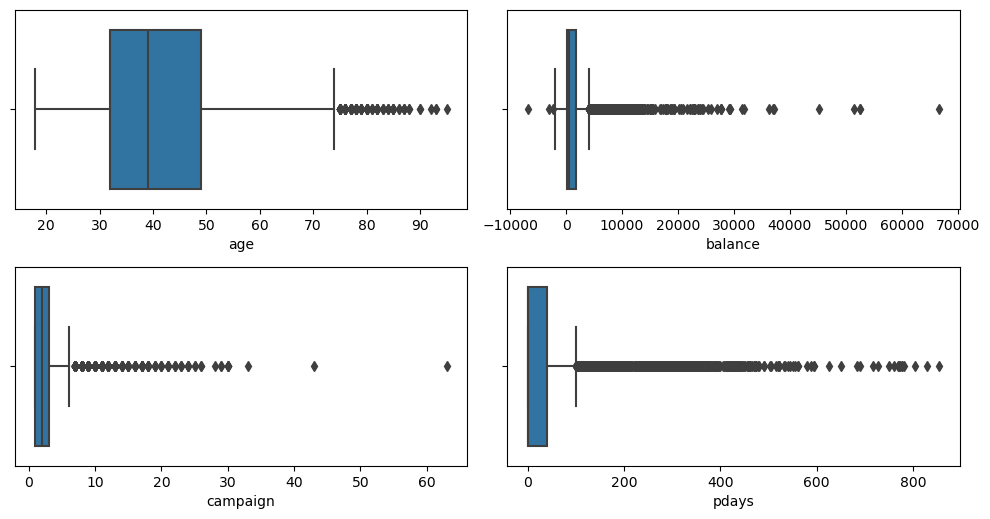

In [91]:
numerik = data_with_outlier.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.boxplot(x = data_with_outlier[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

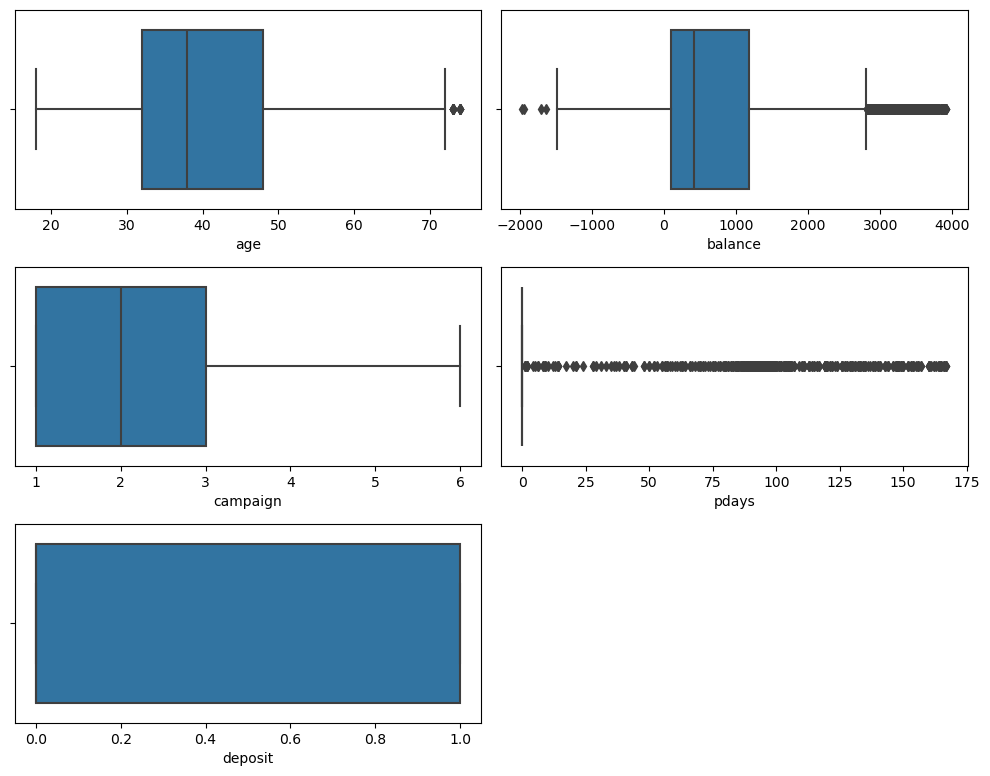

In [90]:
numerik = data_without_outlier.select_dtypes(include = 'number')

# ganti ukuran pigura (wadah grafik nya)
plt.figure(figsize = (10,10))

posisi = 1 # menginisiasi posisi mulai dari 1
for setiap_kolom in numerik.columns: # numerik.columns = nama-nama kolom dalam list
    plt.subplot(4,2,posisi)
    sns.boxplot(x = data_without_outlier[setiap_kolom])
    posisi = posisi + 1
    # agar tidak bertumpuk
    plt.tight_layout()

In [92]:
X_no_outliers = data_without_outlier.drop(columns = 'deposit')
y_no_outliers = data_without_outlier['deposit']
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers,
    y_no_outliers,
    test_size = 0.2,
    random_state = 42,
    stratify = y_no_outliers
)

In [122]:
X_train_no_outliers.shape, X_test_no_outliers.shape, y_train_no_outliers.shape, y_test_no_outliers.shape

((4413, 10), (1104, 10), (4413,), (1104,))

In [123]:
from imblearn.pipeline import Pipeline


train_score_list = []
train_score_std_list = []
test_score_list = []
for i in [lr, dt, knn, vc_soft, vc_hard, stacking, rf, gb, xgb]:
    model = Pipeline([
        ('transformer', transformer),
        ('model', i)
    ])
    # Train model
    score = cross_val_score(model, X_train_no_outliers, y_train_no_outliers, cv = StratifiedKFold(n_splits = 5), scoring = 'f1')
    # menghitung mean f1 score setiap split
    train_score_list.append(score.mean())
    # menghitung standar deviasi
    train_score_std_list.append(score.std())

    # Prediksi
    model.fit(X_train_no_outliers, y_train_no_outliers)
    ypred_test = model.predict(X_test_no_outliers)

    # Evaluasi
    test_score = f1_score(y_test_no_outliers, ypred_test)
    test_score_list.append(test_score)

In [124]:
data3 = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'KNN', 'VC Soft', 'VC Hard', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'matrics score' : 'Recall',
    'train_score_mean': train_score_list,
    'train_score_std': train_score_std_list,
    'test_score': test_score_list}).sort_values(by = 'test_score', ascending = False)
data3

,model,matrics score,train_score_mean,train_score_std,test_score
8,XGBoost,Recall,0.591871,0.016525,0.591457
7,Gradient Boosting,Recall,0.607046,0.029039,0.585018
4,VC Hard,Recall,0.582915,0.023926,0.580645
2,KNN,Recall,0.583962,0.020125,0.580367
5,Stacking,Recall,0.586394,0.020299,0.569106
6,Random Forest,Recall,0.597129,0.025254,0.564984
3,VC Soft,Recall,0.567389,0.021087,0.559162
0,Logistic Regression,Recall,0.564676,0.032062,0.556075
1,Decision Tree,Recall,0.546441,0.015501,0.542857


Dengan eksperiment Hapus Oulier maka XGBoost menjadi algoritma terbaik sebesar 59%

### Resampling for Balancing

Dari hasil perbandingan depositor antara '1 (Yes)' dan '0 (No)' relatif seimbang, sehingga tidak diperlukan balancing. Maka akan cek .

In [118]:
# tanpa resample

model_basic = Pipeline([
    ('preproses', transformer),
    ('model', meta_model)
])
model_basic.fit(X_train,y_train)
y_pred_basic = model_basic.predict(X_test)
print(classification_report(y_test, y_pred_basic))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       816
           1       0.69      0.60      0.64       747

    accuracy                           0.68      1563
   macro avg       0.68      0.68      0.68      1563
weighted avg       0.68      0.68      0.68      1563



In [116]:
# dengan resampling random over sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

meta_model = LogisticRegression(random_state=42)
rus = RandomUnderSampler(random_state=42)
model_rus = Pipeline([
    ('preprocess', transformer),
    ('resampling', rus),
    ('model', meta_model)
])
model_rus.fit(X_train,y_train)
y_pred_rus = model_rus.predict(X_test)
print(classification_report(y_test, y_pred_rus))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       816
           1       0.67      0.64      0.65       747

    accuracy                           0.67      1563
   macro avg       0.67      0.67      0.67      1563
weighted avg       0.67      0.67      0.67      1563



In [117]:
#dengan resampling SMOTE
smote = SMOTE(random_state = 42)
model_smote = Pipeline([
    ('preprocess', transformer),
    ('resampling', smote),
    ('model', meta_model)
])
model_smote.fit(X_train,y_train)
y_pred_smote = model_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       816
           1       0.67      0.64      0.65       747

    accuracy                           0.67      1563
   macro avg       0.67      0.67      0.67      1563
weighted avg       0.67      0.67      0.67      1563



Dari hasil pengujian resampling(Random Under Sampling dan Smote) tidak merubah jauh skor dari evaluasi metrics(precision, recall, f1-score), maka dari itu penggunaan resampling tidak disarankan pada data ini karena nanti hanya akan membuat data menjadi bias dan hasil dari evaluasi matrics nya tidak lebih bagus dari sebelum di resampling.

### Hasil Eksperimen

In [144]:
data1['eksperimen'] = 'Rule Based'
df1['eksperimen'] = 'Based Model'
data3['eksperimen'] = 'Without Outliers'


# penggabungan semua df score
data_gab = pd.concat([data1, df1, data3], axis = 0)
data_gab = data_gab.set_index(['eksperimen','model'])

# highlight ke score terbaik
data_gab.style.highlight_max(subset = ['train_score_mean','test_score'],color = 'lightgreen', axis = 0).highlight_min(subset = ['train_score_std'],color = 'lightgreen', axis = 0)

### Final Model

Dari hasil experiment yang kita lakukan dapat kita ketahui bahwa model yang paling bagus dalam melakukan analisis adalah model VC Soft dan Random forest dengan experiment based model, selanjutnya kita menggunakan model VC Soft untuk melakukan analisis pada tahap selanjutnya

In [154]:
best_model = Pipeline([
    ('transformer', transformer),
    ('model', vc_soft)
])

best_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['housing', 'loan', 'contact',
                                                   'poutcome']),
                                                 ('binary', BinaryEncoder(),
                                                  ['job']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'month',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': jan     1
feb     2
mar     3
apr     4
may     5
jun     6
jul     7
aug     8
sep     9
oct    10
nov    11
dec    12
dtype: int64}]),
                                                  ['month']),
                                                 ('scaler', RobustScaler(),
                                                  Index(['age', 'balance', 'campaign', 'pdays'], dtype='object'))])),
                ('model',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(max_iter=1000)),
                                              ('dt',
                                               DecisionTreeClassifier(random_state=42)),
                                              ('knn', KNeighborsClassifier())],
                                  voting='soft'))])

In [155]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.66      0.67      0.66       816
           1       0.63      0.62      0.62       747

    accuracy                           0.64      1563
   macro avg       0.64      0.64      0.64      1563
weighted avg       0.64      0.64      0.64      1563

F1 Score: 0.6247464503042597
Recall: 0.6184738955823293


***Transformasi Data dengan transformer***

Pada tahap ini, transformer menggunakan ColumnTransformer yang menggabungkan beberapa teknik preprocessing untuk mempersiapkan data sebelum model dijalankan:

- `OneHotEncoder`: Menerapkan one-hot encoding pada kolom kategori : housing, loan, contact, dan poutcome.
- `BinaryEncoder`: Menerapkan binary encoding pada kolom kategori yang memiliki banyak nilai unik seperti job 
- `OrdinalEncoder`: Menerapkan ordinal encoding pada kolom kategori yang memiliki banyak nilai berurutan month 
- `RobustScaler`: Melakukan normalisasi data numerik untuk mengurangi dampak outliers.
- `remainder='passthrough`': Kolom-kolom yang tidak mengalami transformasi akan dilewatkan tanpa perubahan.

### Hypertuning

Untuk mendapatkan peforma yang baik maka akan dicoba melakukan hypertuning dengan GridSearchCV digunakan untuk mencari kombinasi parameter terbaik untuk setiap model yang digunakan dalam Voting Classifier. Parameter yanga akan diuji :
- 'model__lr__C': Ini adalah parameter regularisasi untuk Logistic Regression. 
-'model__dt__max_depth': Ini adalah parameter maximum depth untuk Decision Tree. 
- 'model__knn__n_neighbors': Ini adalah parameter jumlah tetangga yang digunakan dalam K-Nearest Neighbors untuk menentukan banyak tetangga terdekat.


In [171]:
# Definisikan parameter grid untuk setiap model dalam Voting Classifier
param_grid = {
    'model__lr__C': [0.1, 1.0, 10],  # Logistic Regression regularization parameter
    'model__dt__max_depth': [None, 10, 20],  # Decision Tree depth
    'model__knn__n_neighbors': [3, 5, 7]  # KNN number of neighbors
}

In [172]:
# Lakukan Grid Search pada pipeline yang sudah dibuat
grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, scoring='f1')

# Latih Grid Search dengan data training
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'poutcome']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['job']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'month',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': jan     1
feb     2
mar     3
apr     4
may     5
jun     6
jul     7
aug     8
sep     9...
                                                                         Index(['age', 'balance', 'campaign', 'pdays'], dtype='object'))])),
                                       ('model',
                                        VotingClassifier(estimators=[('lr',
                                                                      LogisticRegression(max_iter=1000)),
                                                                     ('dt',
                                                                      DecisionTreeClassifier(random_state=42)),
                                                                     ('knn',
                                                                      KNeighborsClassifier())],
                                                         voting='soft'))]),
             param_grid={'model__dt__max_depth': [None, 10, 20],
                         'model__knn__n_neighbors': [3, 5, 7],
                         'model__lr__C': [0.1, 1.0, 10]},
             scoring='f1')

In [173]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__dt__max_depth,param_model__knn__n_neighbors,param_model__lr__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.125612,0.021361,0.059647,0.003552,10,5,1.0,"{'model__dt__max_depth': 10, 'model__knn__n_ne...",0.645221,0.660413,0.614203,0.627341,0.629063,0.635248,0.015977,1
12,0.128795,0.014759,0.061639,0.006595,10,5,0.1,"{'model__dt__max_depth': 10, 'model__knn__n_ne...",0.645221,0.661668,0.610526,0.627341,0.629063,0.634764,0.017368,2
14,0.121232,0.016664,0.058302,0.005346,10,5,10,"{'model__dt__max_depth': 10, 'model__knn__n_ne...",0.643974,0.659155,0.614203,0.627341,0.629063,0.634747,0.015428,3
11,0.122336,0.022592,0.052515,0.002925,10,3,10,"{'model__dt__max_depth': 10, 'model__knn__n_ne...",0.648501,0.646240,0.615962,0.615955,0.625235,0.630379,0.014299,4
10,0.122698,0.021330,0.051202,0.002404,10,3,1.0,"{'model__dt__max_depth': 10, 'model__knn__n_ne...",0.648501,0.646240,0.615962,0.615955,0.624647,0.630261,0.014343,5


In [174]:
# Output hasil terbaik
print(f"Best parameters: {grid_search.best_params_}\n")
print(f"Best f1 score: {grid_search.best_score_}")

Best parameters: {'model__dt__max_depth': 10, 'model__knn__n_neighbors': 5, 'model__lr__C': 1.0}

Best f1 score: 0.6352481445175678


In [175]:
# Gunakan model terbaik yang ditemukan oleh Grid Search
best_vc_soft_model = grid_search.best_estimator_

# Evaluasi pada data test
y_pred_best_tuning = best_vc_soft_model.predict(X_test)
print(classification_report(y_test, y_pred_best_tuning))
print(f'F1 Score: {f1_score(y_test, y_pred_best_tuning)}')

              precision    recall  f1-score   support

           0       0.67      0.82      0.74       816
           1       0.74      0.56      0.64       747

    accuracy                           0.70      1563
   macro avg       0.71      0.69      0.69      1563
weighted avg       0.70      0.70      0.69      1563

F1 Score: 0.6403641881638846


In [176]:
#Perbandingan recall final model dengan tuning dan tanpa tuning
pd.DataFrame({
    'Model': ['Final Model Tanpa tuning', 'Final Model Dengan tuning'],
    'F1 Score': [f1_score(y_test, y_pred), f1_score(y_test, y_pred_best_tuning)]
})

,Model,F1 Score
0,Final Model Tanpa tuning,0.624746
1,Final Model Dengan tuning,0.640364


Dapat disimpukan bahwa model yang dipilih yaitu dengan menggunkan hypertuning karena memiliki hasil lebih tinggi dibanding tanpa tunning.

# Final Model Interpretation

## Feature Importances

Karena VotingClassifier adalah gabungan dari beberapa model (ensemble) dan tidak secara langsung mendukung pengukuran feature importance maka perlu dilakukan loop untuk mendpatkan feature impotance dari model.

In [182]:
vc_model = best_model.named_steps['model']

In [183]:
feature_importances_all = []

In [185]:
# Loop untuk mendapatkan feature importance dari model-model yang mendukungnya
for model in vc_model.estimators_:
    # Cek apakah model memiliki feature_importances_ (seperti Random Forest, Decision Tree)
    if hasattr(model, 'feature_importances_'):
        feature_importances_all.append(model.feature_importances_)
    # Jika model memiliki koefisien (seperti Logistic Regression)
    elif hasattr(model, 'coef_'):
        feature_importances_all.append(model.coef_[0])

In [186]:
# Rata-rata atau agregasi feature importance dari setiap model
feat_imp = np.mean(feature_importances_all, axis=0)

# Mendapatkan nama-nama fitur setelah preprocessing
features = best_model.named_steps['transformer'].get_feature_names_out()

df_feat_imp = pd.DataFrame({
    'features': features,
    'importance': feat_imp
}).sort_values(by='importance', ascending=False)

df_feat_imp

,features,importance
4,one hot__poutcome_success,1.091165
11,scaler__balance,0.191687
10,scaler__age,0.067719
13,scaler__pdays,0.062807
5,binary__job_0,0.058993
9,ordinal__month,0.042902
2,one hot__contact_telephone,-0.008518
7,binary__job_2,-0.014084
3,one hot__poutcome_other,-0.021060
6,binary__job_1,-0.024352


<Axes: xlabel='importance', ylabel='features'>

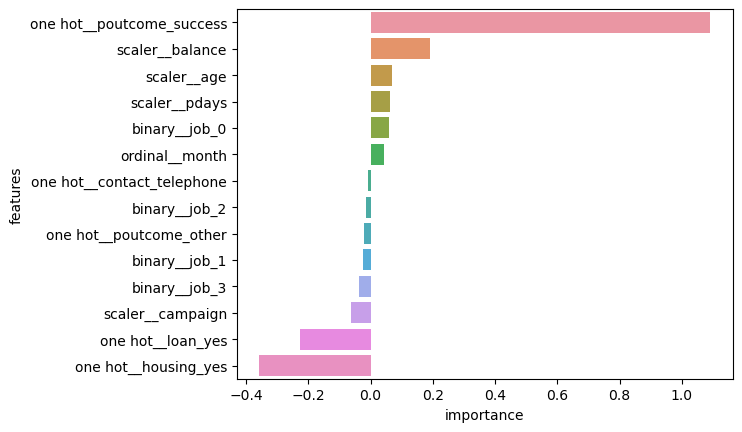

In [187]:
sns.barplot(x = 'importance', y = 'features', data = df_feat_imp)

Dari barplot diatas disimpulkan :

**Fitur Positif**

* Fitur one hot__poutcome_success memiliki nilai importance tertinggi (1.091165). Ini berarti, status outcome success pada campaign sebelumnya sangat mempengaruhi hasil prediksi model.
* scaler__balance juga penting dengan nilai (0.191687), yang berarti saldo nasabah juga mempengaruhi keputusan prediksi model, meskipun pengaruhnya tidak sebesar poutcome_success.
Nasabah dengan saldo lebih tinggi lebih cenderung untuk merespon positif.


**Fitur Negatif**

* Fitur one hot__housing_yes memiliki nilai importance negatif (-0.357374). Ini berarti, nasabah yang memiliki rumah ("yes") memberikan pengaruh negatif terhadap hasil prediksi, atau lebih cenderung tidak memenuhi target yang diharapkan.
* one hot__loan_yes juga memiliki pengaruh negatif (-0.227883), menunjukkan bahwa nasabah yang memiliki pinjaman juga mengurangi peluang untuk memenuhi target prediksi.
'Housing' dan ' loan' dan personal loan yang dimiliki nasabah cenderung mengurangi kemungkinan mereka merespon positif. Ini bisa mengindikasikan bahwa nasabah yang memiliki kewajiban finansial cenderung tidak merespon secara positif.

## Limitasi

Berikut tabel limitasi untuk setiap fitur

|Feature|Range|
|-------|-----|
|age |	18 - 95 |
|job |	'admin.', 'housemaid', 'technician', 'management', 'student', 'services', 'blue-collar', 'entrepreneur', 'retired', 'unemployed', 'self-employed', 'other' |
|balance |	$0 - $66653|
|housing |	Yes, No  |
|loan |	Yes, No |
|contact | telephone, cellular |
|month | january - december |
|campaign| 1 - 63 |
|pdays| 0-854|
|poutcome	| Success, Failure, Other|
|deposito| Yes, No|

## Estimasi Keuntungan

<Axes: >

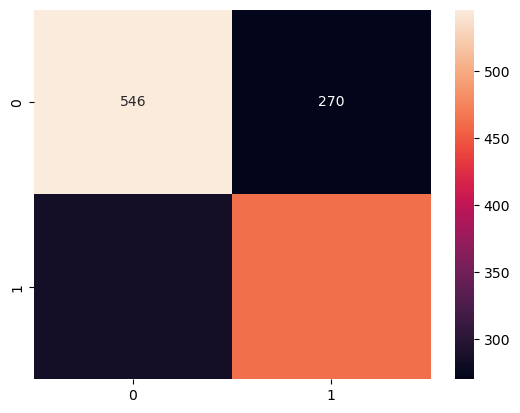

In [188]:
confusion_matrix(y_test,y_pred)

sns.heatmap(confusion_matrix(y_test,y_pred), annot = True, fmt='d')

In [194]:
# Untuk mengetahui nilai sebagai dataframe karena tidak muncul semua
from sklearn.metrics import confusion_matrix

# Contoh confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Ubah confusion matrix menjadi DataFrame
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Tampilkan confusion matrix
print("Confusion Matrix as DataFrame:\n", cm_df)



Confusion Matrix as DataFrame:
           Predicted 0  Predicted 1
Actual 0          546          270
Actual 1          285          462


- TN = 546
- FP = 270

- FN = 285
- TP =462


* True Positives (TP) = 462

Dari model prediksi, 462 nasabah yang diprediksi akan mengikuti program deposito memang benar-benar melakukannya. Artinya, prediksi model untuk nasabah ini akurat.
 
* True Negatives (TN) = 546

Ada 546 nasabah yang diprediksi tidak akan mengikuti deposito, dan kenyataannya memang mereka tidak ikut. Prediksi ini juga akurat.

* False Positives (FP) = 270

Model memprediksi 270 nasabah akan mengikuti program deposito, namun kenyataannya mereka tidak ikut. Ini disebut juga Type I error, yaitu kesalahan di mana model memberikan prediksi positif palsu.

* False Negatives (FN) = 285

Sebanyak 285 nasabah diprediksi tidak akan mengikuti program deposito, tetapi kenyataannya mereka ikut. Ini disebut juga Type II error, yaitu kesalahan di mana model gagal mendeteksi nasabah yang sebenarnya ikut program.


### Perhitungan

**Keuntungan dari True Positives (TP):**

- Nasabah yang tertarik (462 orang): Bank mendapatkan 462 nasabah yang benar-benar melakukan deposito. 
- Contoh perhitungan: Jika satu nasabah yang melakukan deposito rata-rata 300 dolar , maka dana yang terhimpun oleh bank adalah: `462×300=138.600 dolar`.

**Kerugian dari True Negatives (TN):**

- Nasabah yang benar-benar tidak tertarik (546 orang): Bank bisa menghemat biaya pemasaran untuk 546 nasabah ini.
- Contoh perhitungan: Jika biaya untuk menghubungi satu nasabah adalah 15 dolar, maka biaya yang dihemat dari True Negatives adalah:`546×15=8190 dolar.`

**Kerugian dari False Positives (FP):**

- Nasabah yang yang diprediksi tertarik (270 orang) tetapi nasabah tersebut tidak melakukannya, yang berarti bank mungkin telah mengeluarkan biaya pemasaran yang sia-sia.
- Contoh perhitungan: Jika biaya untuk menghubungi satu nasabah adalah 15 dolar, maka kerugian adalah: `270×15=4050 dolar`
- Ini adalah kerugian dari biaya pemasaran yang sia-sia.

**Kerugian dari False Negatives (FN):**

- Nasabah yang terlewatkan (285 orang) dimana dimodel nasbah diprediksi tidak akan melakukan deposito, tetapi sebenarnya mereka bersedia. Bank kehilangan kesempatan untuk mendapatkan pendapatan dari nasabah-nasabah ini.
- Contoh perhitungan: Jika satu nasabah yang melakukan deposito a 300 dolar , maka potensi dana nasabah yang dilewatkan adalah:`285×300=85,300 dolar.`
- Ini adalah dana deposito yang hilang karena nasabah yang terlewatkan oleh model.

# KESIMPULAN

## Rekomendasi untuk model

Model terbaik yang digunakan yaitu VotingClassifier dengan dilakukan hypertunning mendapatkan hasil lebih tinggi. Dengan Hypermeter  f1 score yang memiliki akurasi 64%

Kelemahan: 

*  Akurasi 64% menunjukkan bahwa model tidak cukup kuat dalam memprediksi nasabah yang akan mengikuti program deposito. Ada potensi kesalahan yang signifikan.Sehingga berpotensi terjadi kesalahan yang menyebabkan hilangnya nasabah potensial (false negatives) atau mengganggu nasabah dengan penawaran yang tidak sesuai (false positives).

* Untuk Pengembangan model dengan model lebih canggih seperti XGBoost  yang sering lebih baik hasil prediksinya dan Peninjauan kembali fitur yang ada 

## Rekomendasi untuk Bisnis
Bank dapat memanfaatkan fitur positif untuk menambah target dposito  

1. fitur poutcome_success. Jika hasil campaign sebelumnya berhasil, nasabah ini cenderung lebih mungkin merespon positif pada campaign saat ini.
2. Balance (saldo nasabah) juga signifikan. Nasabah dengan saldo lebih tinggi lebih cenderung untuk merespon positif.

Selain itu Bank juga tidak perlu melakukan penawaran kepada nasabah jika pada fitur housing loan dan personal loan yang dimiliki nasabah cenderung mengurangi kemungkinan mereka merespon positif. Ini bisa mengindikasikan bahwa nasabah yang memiliki kewajiban finansial cenderung tidak merespon secara positif.
